# DSP Assignment-4

## clean所有檔案(如果不想重跑可以跳過)

In [4]:
!make clean

rm -f dft_filter_frame_based_with_fft_time_domain.exe \
      dft_filter_frame_based_with_dft_time_domain.exe \
      dft_filter_dft_based.exe \
      dft_filter_fft_based.exe \
      dft_filter_no_define.exe
Cleaned all build files


## make all
用Jupyter跑會有點卡，建議用終端機
下面是可以單跑某一項

In [ ]:
# !make all
# !make frame_based_with_dft_time_domain
# !make frame_based_with_fft_time_domain
# !make dft_based
# !make fft_based
# !make no_define

## 1. 添加 FFT
```c=
void FFT(float x[N], fftwf_complex X[N]) {
    fftwf_plan p = fftwf_plan_dft_r2c_1d(N, x, X, FFTW_ESTIMATE);
    fftwf_execute(p);
    fftwf_destroy_plan(p);
}

void IFFT(fftwf_complex X[N], float x[N]) {
    fftwf_plan p = fftwf_plan_dft_c2r_1d(N, X, x, FFTW_ESTIMATE); // 一維實數DFT
    fftwf_execute(p);
    fftwf_destroy_plan(p);
    for (int i = 0; i < N; i++) {
        x[i] /= N; // Normalize
    }
}

void conv_by_FFT(float x[N], float h[N], float y[N]) {
    fftwf_complex X[N], H[N], Y[N];
    float temp_x[N], temp_h[N];

    // Zero padding
    memset(temp_x, 0, sizeof(float) * N);
    memset(temp_h, 0, sizeof(float) * N);
    memcpy(temp_x, x, sizeof(float) * L);
    memcpy(temp_h, h, sizeof(float) * P);

    // Compute FFT of x and h
    FFT(temp_x, X);
    FFT(temp_h, H);

    // Perform element-wise multiplication in frequency domain
    for (int k = 0; k < N; k++) {
        Y[k] = X[k] * H[k];
    }

    // Compute IFFT of Y
    IFFT(Y, y);
}
```
`fft3.h`中的 function 筆記：
1. `fftwf_complex`：是一個表示複數數據的結構體。
    ```
    fftw_complex a
    a.re = (實部)
    a.im = (虛部)
    ```
2. `fftwf_plan_dft_r2c_1d`：將時域的一維實數數據轉換為頻域的複數數據。
    ```
    fftw_plan fftw_plan_dft_c2r_1d(int n, fftw_complex *in, double *out, unsigned flags);
    ```
3. `fftwf_execute`：執行 `fftwf_plan p`
4. `fftwf_destroy_plan`：destroy and free `fftwf_plan p`

## 2. 使用 clock_t 計算產生每一個 sample 要花多少 msec?
1. `FRAME_BASED` & `USE_FFT` & `FRAME_BASED_WITH_TIME_DOMAIN`
    * 音檔名稱：out_frame_based_freq_domain_filtering_with_FFT.wav
    * 每一個 sample 要花多少 msec?

    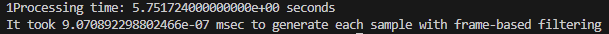

    總時長約為 5.751724000000000 sec
    per sample 時長約為 9.070892298802466e-07 msec

2. `FRAME_BASED` & `USE_DFT` & `FRAME_BASED_WITH_TIME_DOMAIN`
    * 音檔名稱：out_frame_based_freq_domain_filtering_with_DFT.wav
    * 每一個 sample 要花多少 msec?

    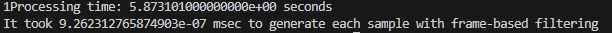

    總時長約為 5.873101000000000 sec
    per sample 時長約為 9.262312765874903e-07 msec

3. `FRAME_BASED` & `USE_FFT`
    * 音檔名稱：out_frame_based_freq_domain_filtering_with_FFT.wav
    * 每一個 sample 要花多少 msec?

    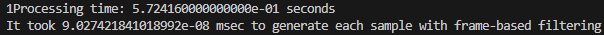

    總時長約為 0.5724160000000000 sec
    per sample 時長約為 9.027421841018992e-08 msec

4. `FRAME_BASED` & `USE_DFT`
    * 音檔名稱：out_frame_based_freq_domain_filtering_with_DFT.wav
    * 每一個 sample 要花多少 msec?

    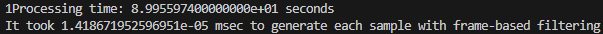

    總時長約為 89.95597400000000 sec
    per sample 時長約為 1.418671952596951e-05 msec

5. 沒有`FRAME_BASED`
    * 音檔名稱：out_sample_based_time_domain_filtering.wav
    * 每一個 sample 要花多少 msec?

    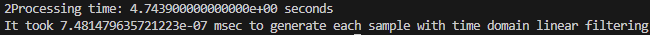

    總時長約為 4.743900000000000 sec
    per sample 時長約為 7.481479635721223e-07 msec

### 結論
1. FFT 比 DFT 快
    當不啟用 `FRAME_BASED_WITH_TIME_DOMAIN` 時，FFT 比 DFT 快 150 倍以上，因為 FFT 的計算更高效（適合處理大樣本數）
2. 使用 `FRAME_BASED_WITH_TIME_DOMAIN` 拉近 FFT 和 DFT 的差距
    啟用 `FRAME_BASED_WITH_TIME_DOMAIN` 後，FFT 和 DFT 的效率差不多，因為 frame 分割減少了樣本數，FFT 的優勢變小

## 解決 precision 問題
解決方法：先都使用 float ，到最後存檔再轉成 short
改的地方：
```c=
typedef struct _wav {
	int fs;
	char header[44];
	size_t length;
	float *LChannel; // 改成float
	float *RChannel; // 改成float
} wav;
```
```c=
p_wav->LChannel = (float *) calloc(p_wav->length, sizeof(float));
p_wav->RChannel = (float *) calloc(p_wav->length, sizeof(float));
for(i=0;i<p_wav->length;i++) {
		fread(p_wav->LChannel+i, sizeof(float), 1, fp);
		fread(p_wav->RChannel+i, sizeof(float), 1, fp);
	}
```
存檔的時候改成short
```c=
for (size_t i = 0; i < p_wav->length; i++) {
        short left = (short)roundf(p_wav->LChannel[i]);
        short right = (short)roundf(p_wav->RChannel[i]);
        fwrite(&left, sizeof(short), 1, fp);
        fwrite(&right, sizeof(short), 1, fp);
    }
```
